<a href="https://colab.research.google.com/github/AnastasiaBrinati/experiments/blob/main/Models120s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **PROVA MODELLI CENTRALIZZATI PREDIZIONE INVOCATIONS' RATE**



#### Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

!pip install -q -U keras-tuner
import keras_tuner as kt

# Use seaborn for pairplot.
!pip install datasets

from datasets import load_dataset

# Data

In [2]:
dataset_120 = load_dataset("anastasiafrosted/globus_120", download_mode="force_redownload")
dataset_300 = load_dataset("anastasiafrosted/globus_300", download_mode="force_redownload")

df_120 = pd.DataFrame(dataset_120['train'])
df_300 = pd.DataFrame(dataset_300['train'])

# Ensure the `timestamp` column is in datetime format
df_120['timestamp'] = pd.to_datetime(df_120['timestamp'])
df_300['timestamp'] = pd.to_datetime(df_300['timestamp'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/558 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.75M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/90833 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/557 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/996k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/37667 [00:00<?, ? examples/s]

In [3]:
data = df_120
data = data.set_index("timestamp")
freq='120s'

In [70]:
origin = "2023-06-15"
start = "2023-07-02" # origin + prediction_lenght
end = "2023-07-08"

train_data = data["2022-12-20":origin]
valid_data = data[origin:start]
test_data = data[start:]

#### Scaling

In [69]:
from sklearn.preprocessing import StandardScaler

# Crea un'istanza dello scaler
scaler = StandardScaler()

# Per il dataset di training
scaled_train = train_data.copy()
scaled_train[scaled_train.columns.drop('avg_invocations_rate')] = scaler.fit_transform(
    train_data[train_data.columns.drop('avg_invocations_rate')]
)
train = scaled_train

# Per il dataset di validazione
scaled_valid = valid_data.copy()
scaled_valid[scaled_valid.columns.drop('avg_invocations_rate')] = scaler.transform(
    valid_data[valid_data.columns.drop('avg_invocations_rate')]
)
valid = scaled_valid

# Per il dataset di test
scaled_test = test_data.copy()
scaled_test[scaled_test.columns.drop('avg_invocations_rate')] = scaler.transform(
    test_data[test_data.columns.drop('avg_invocations_rate')]
)
test = scaled_test

#### Config (Parameters)

In [102]:
batch_size = 32
num_features = 6
sequence_lenght = 7
prediction_lenght = 7

seed = 123
neurons = 32
epochs = 10

# Models

## Forecasting one-step-ahead

In [173]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate=0.01, epochs=epochs):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=10, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae", "mape"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_cb])
    valid_loss, valid_mae, valid_mape = model.evaluate(valid_set)
    return valid_mae, valid_mape

### Univariate series

In [128]:
tr = train['avg_invocations_rate']
vl = valid['avg_invocations_rate']
ts = test['avg_invocations_rate']

In [129]:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    tr.to_numpy(),
    targets=tr[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    vl.to_numpy(),
    targets=vl[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_ds = tf.keras.utils.timeseries_dataset_from_array(
    ts.to_numpy(),
    targets=ts[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=False
)

#### Linear Model

In [171]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[sequence_lenght])
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [174]:
fit_and_evaluate(model, train_ds, valid_ds)

Epoch 1/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0015 - mae: 0.0265 - mape: 45.9727 - val_loss: 6.8578e-04 - val_mae: 0.0184 - val_mape: 35.5628
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.0013 - mae: 0.0250 - mape: 43.0994 - val_loss: 6.3378e-04 - val_mae: 0.0170 - val_mape: 31.6424
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.0013 - mae: 0.0245 - mape: 41.8206 - val_loss: 6.2345e-04 - val_mae: 0.0173 - val_mape: 33.3935
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.0012 - mae: 0.0243 - mape: 41.4369 - val_loss: 6.1002e-04 - val_mae: 0.0165 - val_mape: 30.5533
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.0012 - mae: 0.0242 - mape: 41.1568 - val_loss: 6.0365e-04 - val_mae: 0.0161 - val_mape: 29.1746
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.0012 - mae: 0.0242 - mape: 41.0746 - val_loss: 6.0135e-04 - val_mae: 0.0160 - val_mape: 28.8555
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━

(0.015996407717466354, 28.737232208251953)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


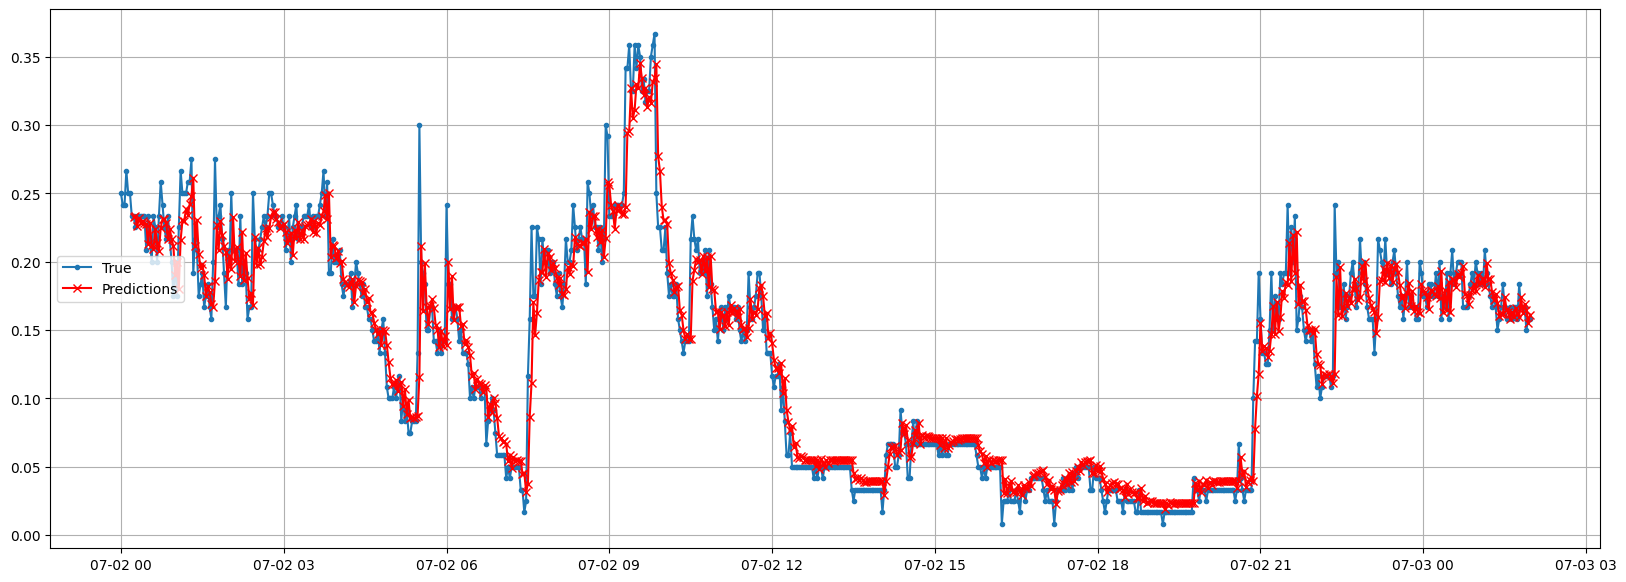

In [175]:
Y_pred = model.predict(test_ds)
Y_pred = pd.Series(Y_pred.flatten(), index=ts.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

#### Simple RNN

Recall that the input_shape argument ignores
the first dimension (i.e., the batch size), and since recurrent layers can accept
input sequences of any length, we can set the second dimension to None, which
means “any size”. Lastly, since we’re dealing with a univariate time series, we
need the last dimension’s size to be 1. This is why we specified the input shape
* [None, 1] : it means “univariate sequences of any length”.


In [105]:
univar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons*2, input_shape=[None, 1]),
  tf.keras.layers.Dense(1) # no activation function by default
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [106]:
fit_and_evaluate(univar_model, train_ds, valid_ds)

Epoch 1/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.0017 - mae: 0.0296 - val_loss: 6.5200e-04 - val_mae: 0.0172
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0012 - mae: 0.0248 - val_loss: 6.0609e-04 - val_mae: 0.0146
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - loss: 0.0012 - mae: 0.0248 - val_loss: 6.0038e-04 - val_mae: 0.0149
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 45s 11ms/step - loss: 0.0012 - mae: 0.0248 - val_loss: 6.0151e-04 - val_mae: 0.0147
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - loss: 0.0012 - mae: 0.0248 - val_loss: 6.0855e-04 - val_mae: 0.0147
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - loss: 0.0012 - mae: 0.0246 - val_loss: 6.2073e-04 - val_mae: 0.0156
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0012 - mae: 0.0248 - val_loss: 6.1119e-04 - val_mae: 0.0159
Epoch 8/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - loss: 0.0012 - mae: 0.0246 - val_loss: 6.2900e-04 - val_mae: 0.016

14398.330822587013

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


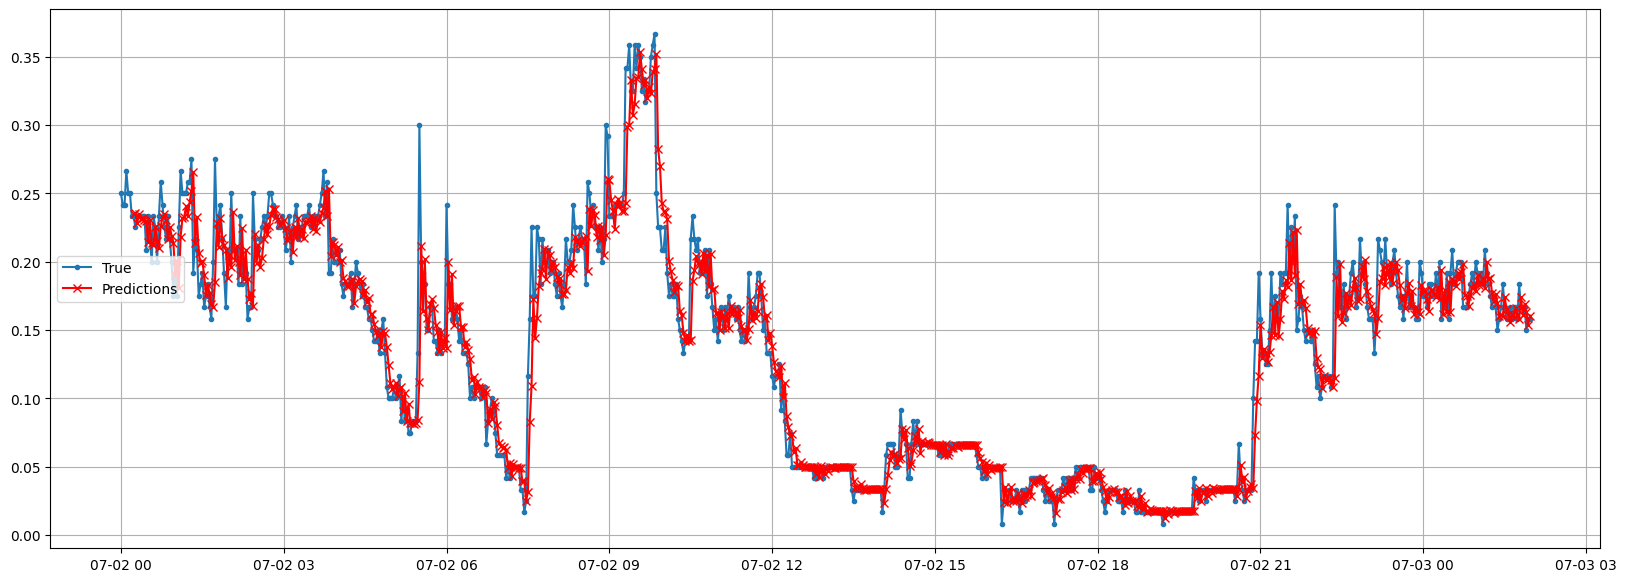

In [107]:
Y_pred = univar_model.predict(test_ds)
Y_pred = pd.Series(Y_pred.flatten(), index=ts.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

#### Deep RNN

In [60]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(neurons*3, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(neurons*2, return_sequences=True),
    tf.keras.layers.SimpleRNN(neurons),
    tf.keras.layers.Dense(1)
])

In [61]:
fit_and_evaluate(deep_model, train_ds, valid_ds)

Epoch 1/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.0037 - mae: 0.0406 - val_loss: 7.0838e-04 - val_mae: 0.0202
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0013 - mae: 0.0278 - val_loss: 5.9869e-04 - val_mae: 0.0145
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - loss: 0.0012 - mae: 0.0265 - val_loss: 8.1139e-04 - val_mae: 0.0273
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - loss: 0.0012 - mae: 0.0267 - val_loss: 6.2359e-04 - val_mae: 0.0169
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - loss: 0.0012 - mae: 0.0261 - val_loss: 6.2044e-04 - val_mae: 0.0161
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - loss: 0.0012 - mae: 0.0260 - val_loss: 6.0118e-04 - val_mae: 0.0148
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 0.0012 - mae: 0.0264 - val_loss: 7.1299e-04 - val_mae: 0.0232
Epoch 8/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 0.0012 - mae: 0.0259 - val_loss: 6.4650e-04 - val_mae:

14509.133994579315

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


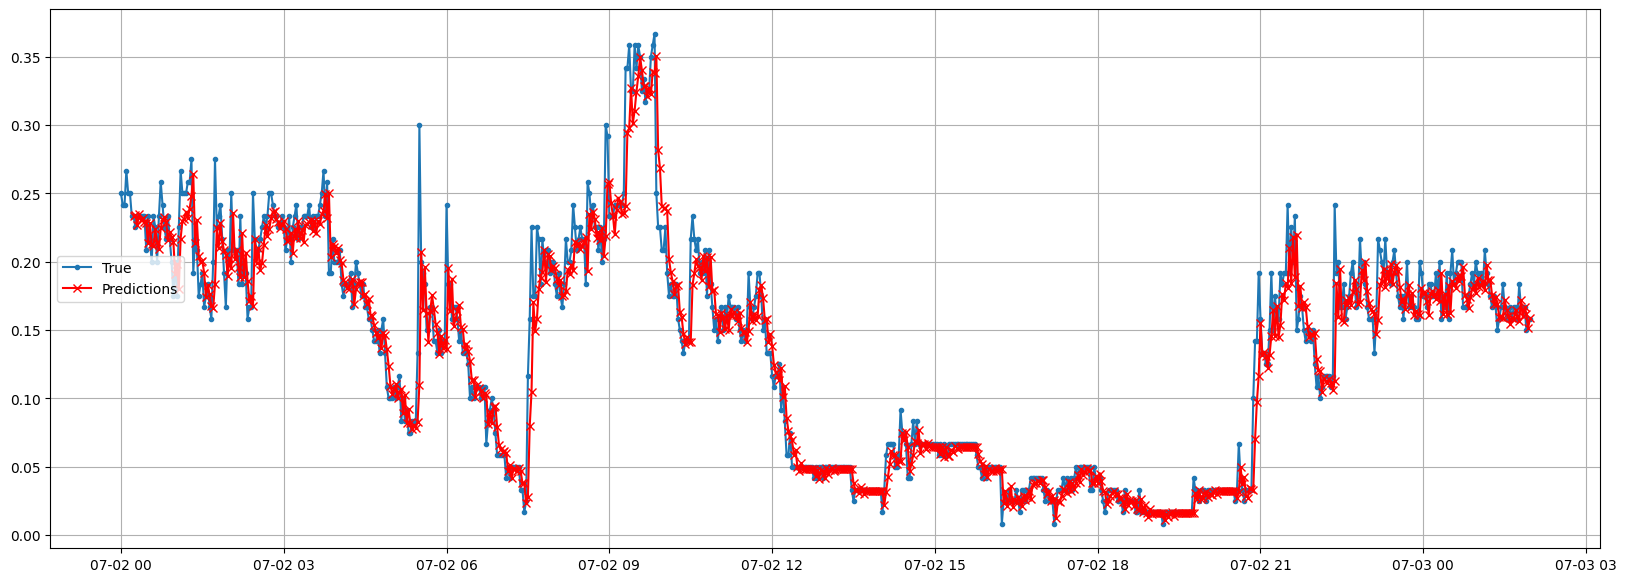

In [62]:
Y_pred = deep_model.predict(test_ds)
Y_pred = pd.Series(Y_pred.flatten(), index=ts.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

### Multivariate Series

In [100]:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    train,
    targets=train['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid,
    targets=valid['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    test,
    targets=test['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Simple RNN

Notice that the only difference from the univar_model RNN we built earlier
is the input shape: at each time step, the model now receives num_features inputs instead of one.

In [63]:
mulvar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons, input_shape=[None, num_features]),
  tf.keras.layers.Dense(1)
])

In [64]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds)

Epoch 1/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 0.0075 - mae: 0.0574 - val_loss: 7.2014e-04 - val_mae: 0.0179
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.0014 - mae: 0.0273 - val_loss: 6.7641e-04 - val_mae: 0.0173
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0012 - mae: 0.0256 - val_loss: 6.5444e-04 - val_mae: 0.0168
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0012 - mae: 0.0248 - val_loss: 6.3061e-04 - val_mae: 0.0156
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.0012 - mae: 0.0244 - val_loss: 6.2273e-04 - val_mae: 0.0162
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0012 - mae: 0.0242 - val_loss: 6.2697e-04 - val_mae: 0.0163
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0011 - mae: 0.0239 - val_loss: 6.1807e-04 - val_mae: 0.0163
Epoch 8/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0011 - mae: 0.0238 - val_loss: 6.3344e-04 - val_mae: 0.0170

15638.386830687523

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


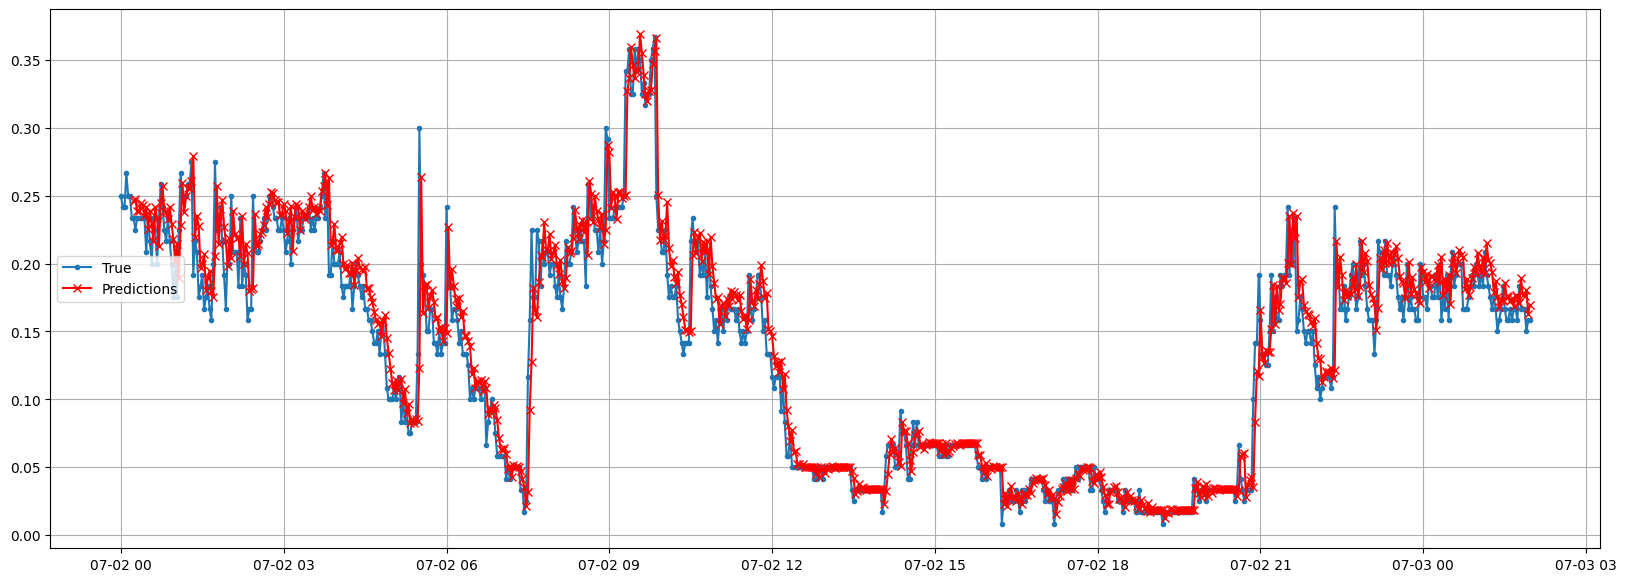

In [65]:
Y_pred = mulvar_model.predict(test_mulvar_ds)
Y_pred = pd.Series(Y_pred.flatten(), index=ts.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

## Forecasting Several Time Steps Ahead

### Univariate Series

Consideriamo sempre:
* tr = train['avg_invocations_rate']
* vl = valid['avg_invocations_rate']

#### Simple RNN

The first option is to take the univar_model RNN we trained earlier for the
rail time series, make it predict the next value, and add that value to the inputs,
acting as if the predicted value had actually occurred; we would then use the
model again to predict the following value, and so on.

---
If the model makes an error at one time step, then the forecasts for the
following time steps are impacted as well: the errors tend to accumulate.
So, it’s preferable to use this technique only for a small number of steps.

 1 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
 2 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
 3 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
 4 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
 5 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
 6 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
 7 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


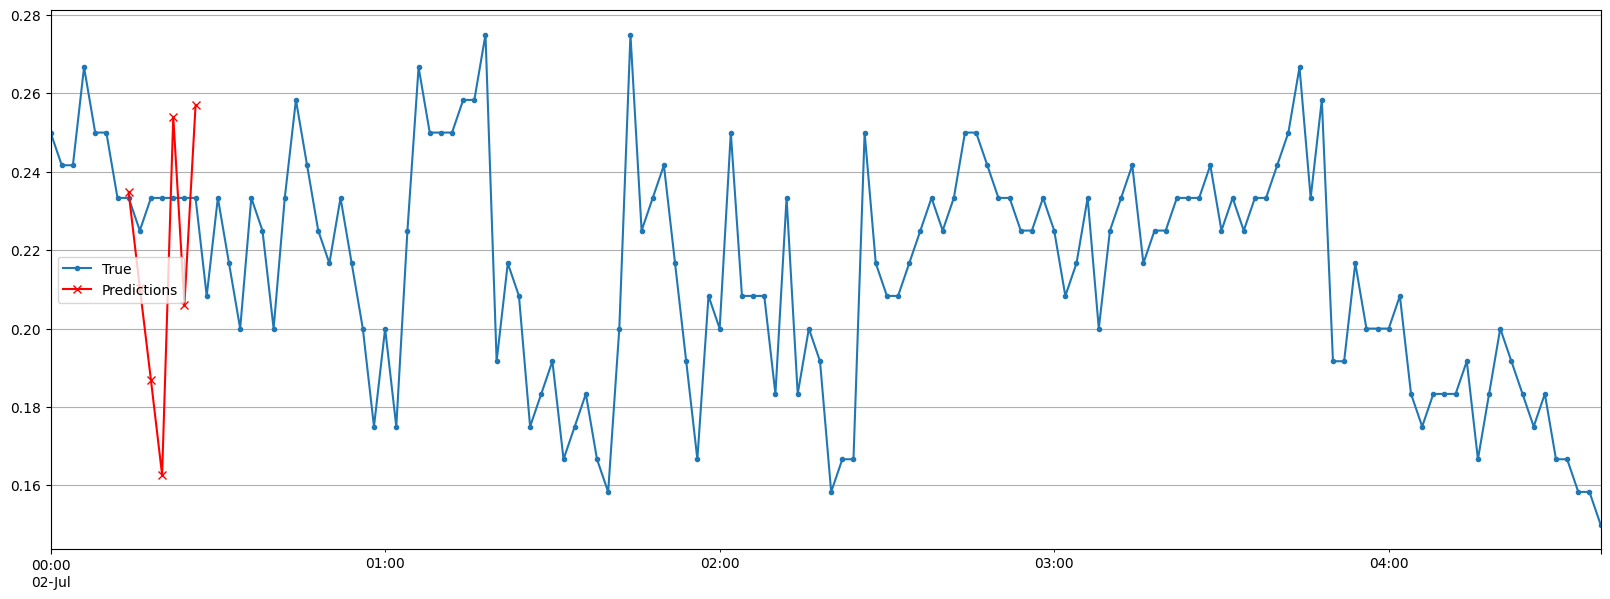

In [176]:
# from -21 to -7 for predicting one by one the last 7 points
X = ts.to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
# run a for loop running multiple times the univar_model and extract the last prediction each time
# concatenate that to the data and keep predicting
for step_ahead in range(prediction_lenght):
  print(f" {step_ahead+1} step ahead")
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start=ts.index[sequence_lenght], end=ts.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts[:(sequence_lenght*20)])[start:start].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### Deep RNN

 1 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
 2 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
 3 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
 4 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
 5 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 6 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
 7 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


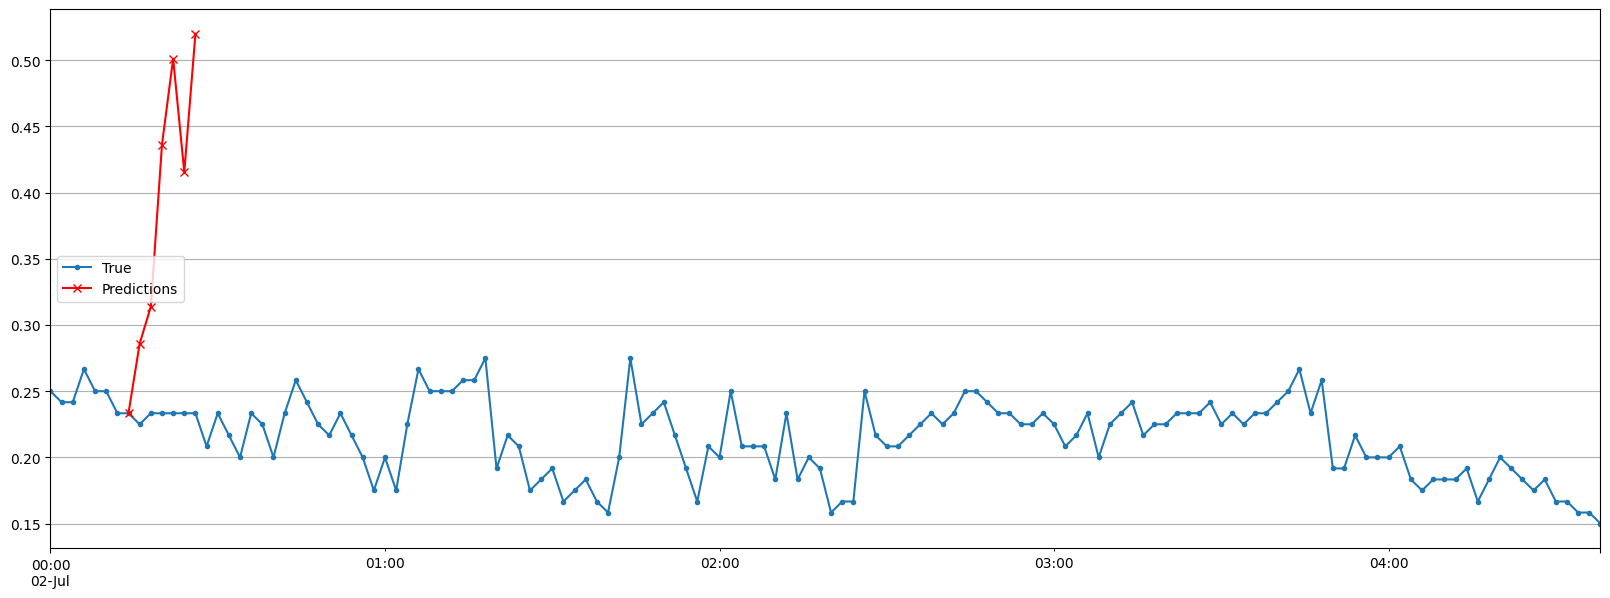

In [177]:
# from -21 to -7 for predicting one by one the last 7 points
X = ts.to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
# run a for loop running multiple times the univar_model and extract the last prediction each time
# concatenate that to the data and keep predicting
for step_ahead in range(prediction_lenght):
  print(f" {step_ahead+1} step ahead")
  y_pred_one = deep_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start=ts.index[prediction_lenght], end=ts.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts[:(sequence_lenght*20)])[start:start].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

### Multivariate Series

In [144]:
def split_inputs_and_targets(mulvar_series, ahead=prediction_lenght, target_col=1):
  return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    train,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

ahead_test_ds = tf.keras.utils.timeseries_dataset_from_array(
    test,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

#### Sequence-to-Vector RNN

Train an RNN to predict the next 14 values in one shot.

In [155]:
ahead_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [156]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds)

Epoch 1/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.1747 - mae: 0.4018 - val_loss: 0.0558 - val_mae: 0.1997
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.1435 - mae: 0.3526 - val_loss: 0.0539 - val_mae: 0.1793
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.1414 - mae: 0.3495 - val_loss: 0.0573 - val_mae: 0.2191
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.1401 - mae: 0.3473 - val_loss: 0.0535 - val_mae: 0.1850
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 0.1392 - mae: 0.3455 - val_loss: 0.0556 - val_mae: 0.2013
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.1388 - mae: 0.3449 - val_loss: 0.0532 - val_mae: 0.1795
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 0.1382 - mae: 0.3439 - val_loss: 0.0535 - val_mae: 0.1805
Epoch 8/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.1378 - mae: 0.3432 - val_loss: 0.0561 - val_mae: 0.2120
Epoch 9/10
2499/2499 ━━━━━━━━━━

179309.6512556076

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


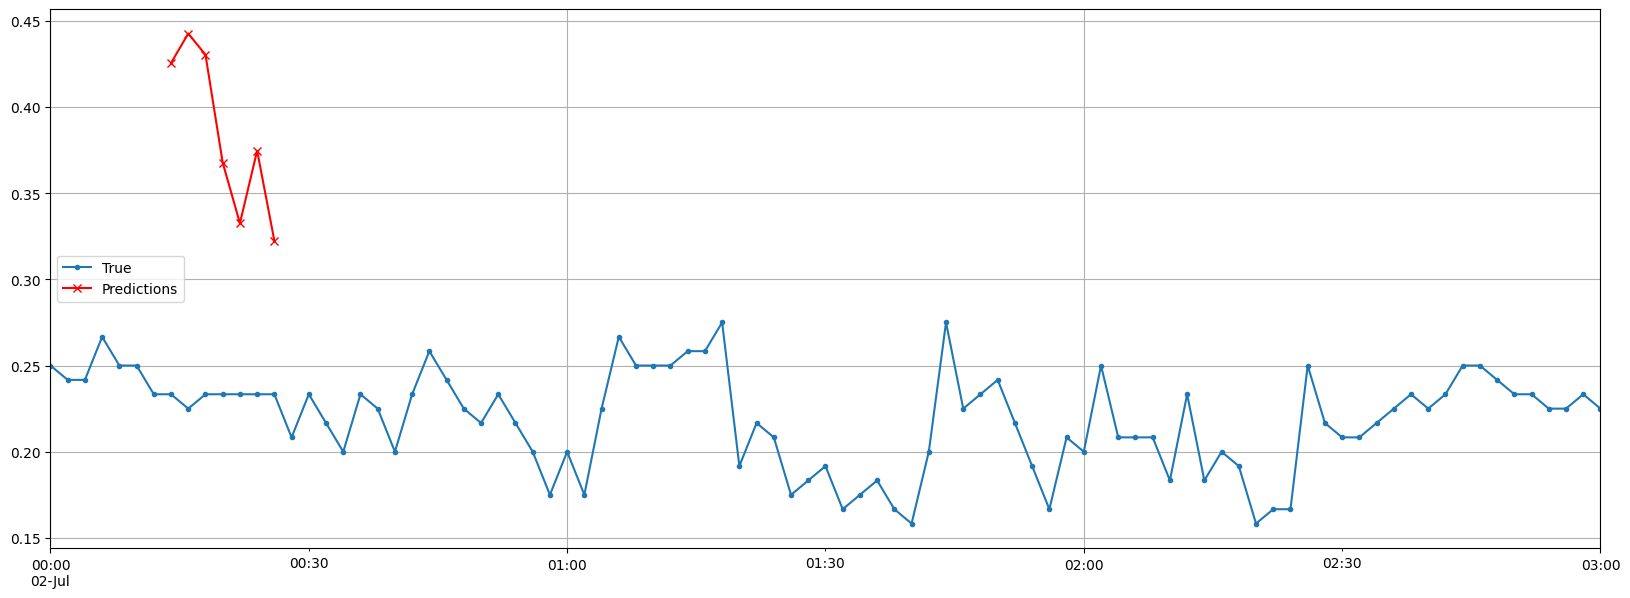

In [213]:
X = test.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = ahead_model.predict(X)
Y_pred = pd.Series(Y_pred[0], index=pd.date_range(start=ts.index[sequence_lenght], end=ts.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts)["2023-07-02 00:00":"2023-07-02 03:00"].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
plt.show()

#### Sequence-to-Sequence RNN

In [181]:
def to_windows(dataset, length):
  dataset = dataset.window(length, shift=1, drop_remainder=True)
  return dataset.flat_map(lambda window_ds: window_ds.batch(length))

def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1, batch_size=32, shuffle=False, seed=None):
  ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
  ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
  if shuffle:
    ds = ds.shuffle(8 * batch_size, seed=seed)
  return ds.batch(batch_size)

In [182]:
seq2seq_train = to_seq2seq_dataset(train, seq_length=sequence_lenght, ahead=prediction_lenght, shuffle=True, seed=seed)
seq2seq_valid = to_seq2seq_dataset(valid, seq_length=sequence_lenght, ahead=prediction_lenght)
seq2seq_test = to_seq2seq_dataset(test, seq_length=sequence_lenght, ahead=prediction_lenght)

Instead of training the model to forecast the next 14 values only at the very last time step, we can train it to forecast the next 14 values at each and every time step.
In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN.

* The targets are sequences of consecutive windows, shifted by one time step at each time step;
* The target is not a vector anymore, but a sequence of the same length as the inputs, containing a (prediction_lenght)-dimensional vector at each step.

It is almost identical to our previous model: the only difference is that we set
return_sequences=True in the SimpleRNN layer. This way, it will
output a sequence of vectors (each of size 'batch_size'), instead of outputting a single
vector at the last time step. The Dense layer is smart enough to handle
sequences as input: it will be applied at each time step, taking a 'batch_size'-dimensional
vector as input and outputting a 'prediction_lenght'-dimensional vector.

In [183]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(neurons, return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [184]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid)

Epoch 1/10
   2490/Unknown 88s 11ms/step - loss: 0.1821 - mae: 0.4262 - mape: 158.7210

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2499/2499 ━━━━━━━━━━━━━━━━━━━━ 94s 14ms/step - loss: 0.1821 - mae: 0.4261 - mape: 158.7423 - val_loss: 0.0567 - val_mae: 0.1986 - val_mape: 94.3195
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - loss: 0.1530 - mae: 0.3755 - mape: 147.5722 - val_loss: 0.0552 - val_mae: 0.1915 - val_mape: 93.3380
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - loss: 0.1484 - mae: 0.3689 - mape: 145.6022 - val_loss: 0.0548 - val_mae: 0.1842 - val_mape: 93.4372
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 0.1463 - mae: 0.3655 - mape: 144.9476 - val_loss: 0.0545 - val_mae: 0.1837 - val_mape: 92.6965
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - loss: 0.1445 - mae: 0.3625 - mape: 144.1541 - val_loss: 0.0548 - val_mae: 0.1883 - val_mape: 91.9016
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 0.1436 - mae: 0.3606 - mape: 144.0101 - val_loss: 0.0544 - val_mae: 0.1802 - val_mape: 91.6178
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step -

(0.17921069264411926, 90.2004623413086)

Perchè sembra migliorare? dovrebbe peggiorare (?)

In [185]:
Y_pred_valid = seq2seq_model.predict(seq2seq_test)
for ahead in range(prediction_lenght):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=test.index[sequence_lenght + ahead : -prediction_lenght + ahead])
    mae = (preds - test["avg_invocations_rate"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
MAE for +1: 291,093
MAE for +2: 265,032
MAE for +3: 280,172
MAE for +4: 272,194
MAE for +5: 256,522
MAE for +6: 253,808
MAE for +7: 265,761


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


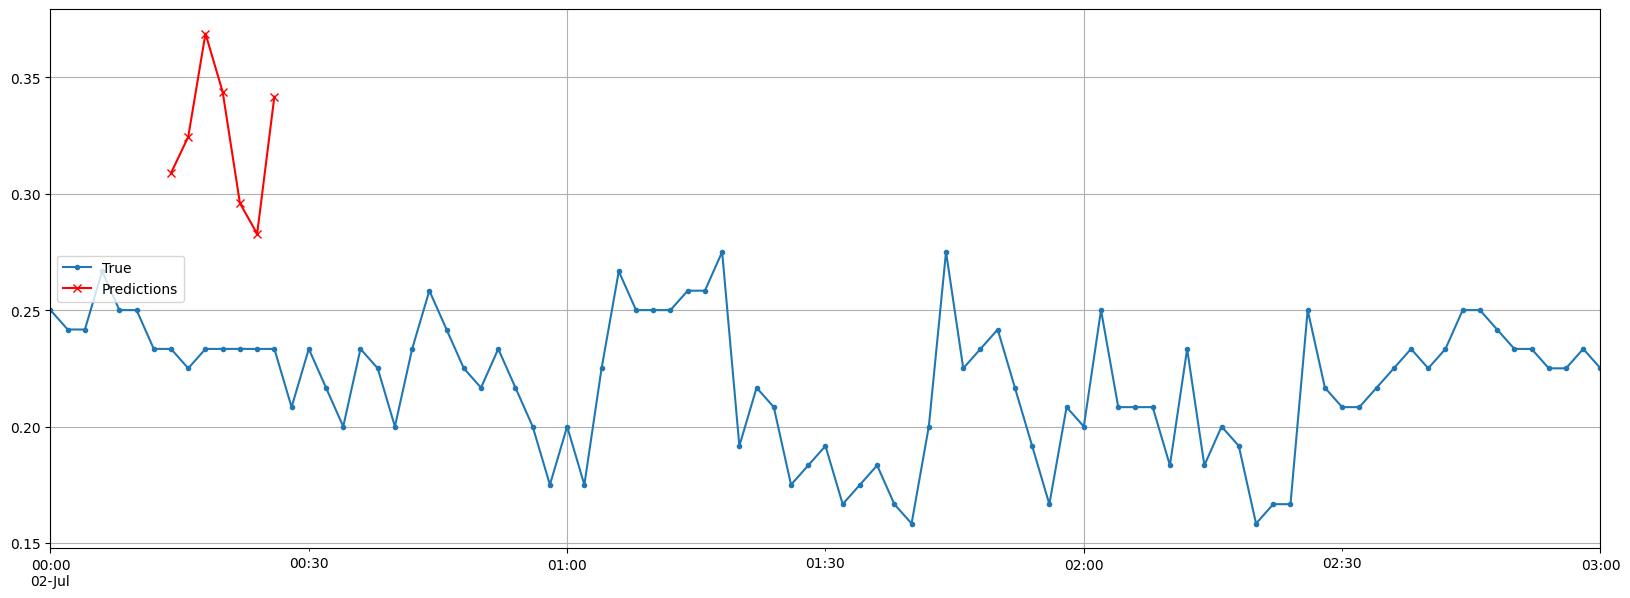

In [214]:
X = test.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts.index[sequence_lenght], end=ts.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts)["2023-07-02 00:00":"2023-07-02 03:00"].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
plt.show()

#### RNN with layer normalization

In [204]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [205]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(neurons), return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [206]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid)

Epoch 1/10
   2497/Unknown 50s 19ms/step - loss: 0.1978 - mae: 0.4491 - mape: 170.4141

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2499/2499 ━━━━━━━━━━━━━━━━━━━━ 56s 22ms/step - loss: 0.1978 - mae: 0.4490 - mape: 170.4121 - val_loss: 0.0555 - val_mae: 0.1735 - val_mape: 96.0021
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - loss: 0.1497 - mae: 0.3712 - mape: 148.1243 - val_loss: 0.0547 - val_mae: 0.1842 - val_mape: 94.2008
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - loss: 0.1461 - mae: 0.3654 - mape: 146.4494 - val_loss: 0.0548 - val_mae: 0.1909 - val_mape: 93.6563
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - loss: 0.1447 - mae: 0.3634 - mape: 146.3015 - val_loss: 0.0542 - val_mae: 0.1814 - val_mape: 93.5763
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - loss: 0.1437 - mae: 0.3612 - mape: 145.2349 - val_loss: 0.0544 - val_mae: 0.1907 - val_mape: 92.7838
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.1429 - mae: 0.3603 - mape: 145.8774 - val_loss: 0.0547 - val_mae: 0.1959 - val_mape: 92.4272
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step -

(0.17347390949726105, 96.0020751953125)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


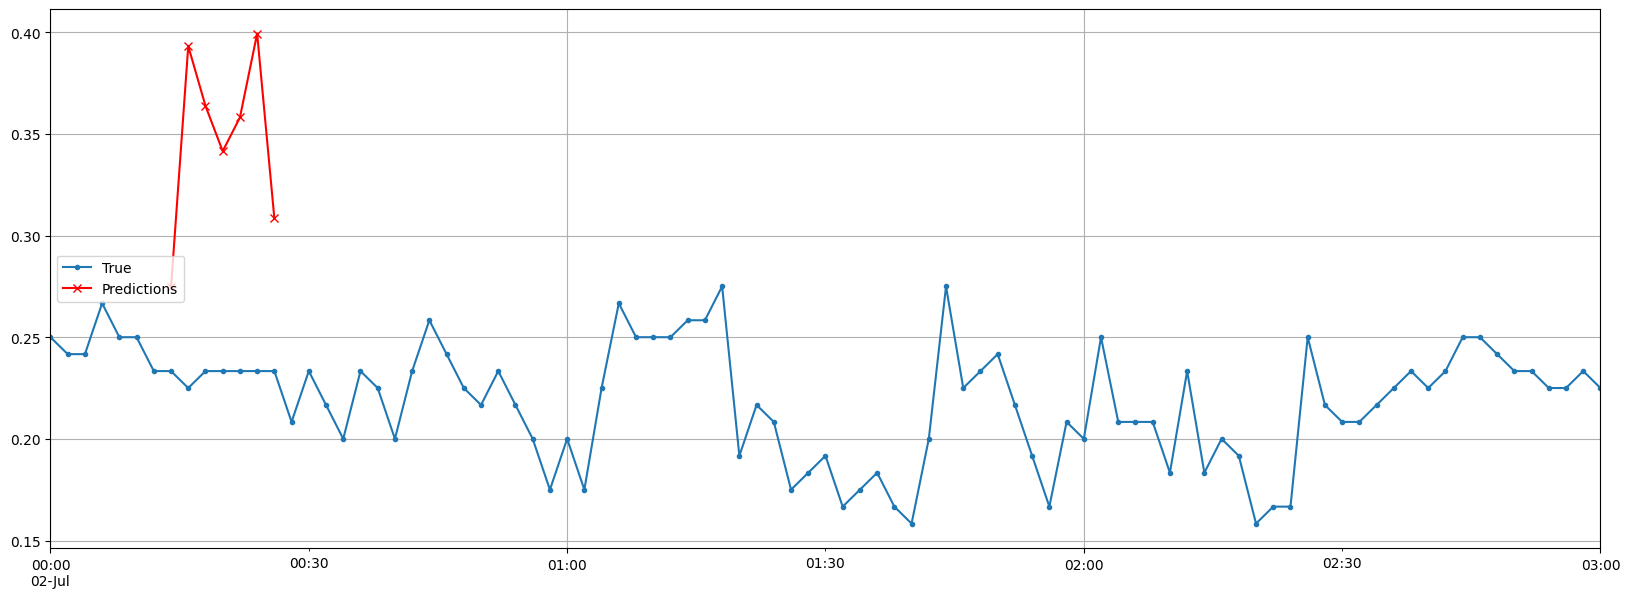

In [215]:
X = test.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = custom_ln_model.predict(X)  # but then [0, -1] because only the last time step's output

Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts.index[sequence_lenght], end=ts.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts)["2023-07-02 00:00":"2023-07-02 03:00"].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
plt.show()

 #### LSTM

In [216]:
lstm = tf.keras.Sequential([
  tf.keras.layers.LSTM(neurons, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [217]:
fit_and_evaluate(lstm, seq2seq_train, seq2seq_valid)

Epoch 1/10
   2498/Unknown 42s 16ms/step - loss: 0.2067 - mae: 0.4616 - mape: 153.9104

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2499/2499 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - loss: 0.2067 - mae: 0.4615 - mape: 153.9149 - val_loss: 0.0590 - val_mae: 0.2107 - val_mape: 95.5736
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - loss: 0.1581 - mae: 0.3824 - mape: 146.7130 - val_loss: 0.0572 - val_mae: 0.2119 - val_mape: 94.7014
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 0.1538 - mae: 0.3761 - mape: 146.1318 - val_loss: 0.0571 - val_mae: 0.2102 - val_mape: 94.1015
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - loss: 0.1514 - mae: 0.3717 - mape: 146.0737 - val_loss: 0.0566 - val_mae: 0.2068 - val_mape: 92.8414
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - loss: 0.1500 - mae: 0.3683 - mape: 145.8200 - val_loss: 0.0564 - val_mae: 0.2068 - val_mape: 92.4641
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 0.1486 - mae: 0.3660 - mape: 145.2450 - val_loss: 0.0561 - val_mae: 0.2068 - val_mape: 91.9541
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step -

(0.20662949979305267, 91.61373138427734)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


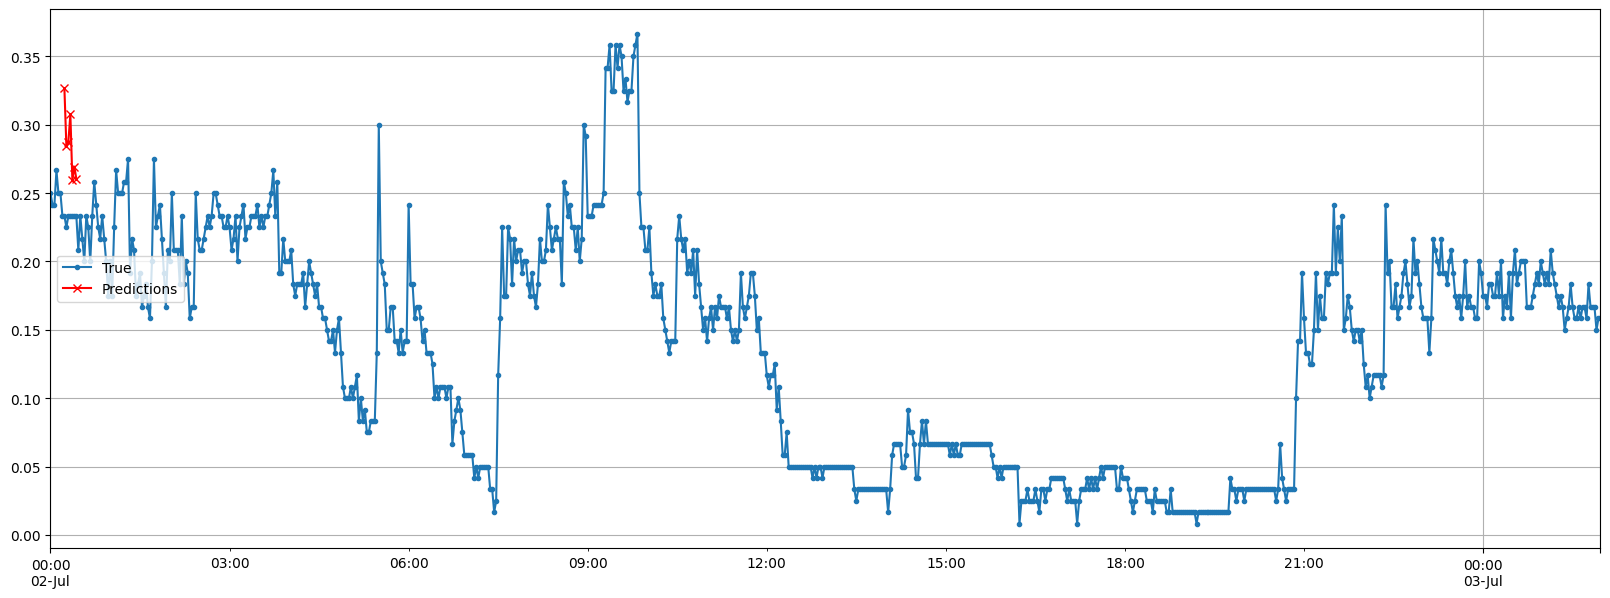

In [218]:
X = test.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = lstm.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts.index[sequence_lenght], end=ts.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
plt.show()

#### GRU

The GRU cell is a simplified version of the LSTM cell...

In [219]:
gru = tf.keras.Sequential([
  tf.keras.layers.GRU(neurons, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [220]:
fit_and_evaluate(gru, seq2seq_train, seq2seq_valid)

Epoch 1/10
   2499/Unknown 42s 16ms/step - loss: 0.1875 - mae: 0.4319 - mape: 152.7542

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2499/2499 ━━━━━━━━━━━━━━━━━━━━ 46s 17ms/step - loss: 0.1875 - mae: 0.4319 - mape: 152.7566 - val_loss: 0.0614 - val_mae: 0.2102 - val_mape: 93.6704
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 99s 24ms/step - loss: 0.1621 - mae: 0.3879 - mape: 147.9361 - val_loss: 0.0599 - val_mae: 0.2046 - val_mape: 94.0005
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - loss: 0.1584 - mae: 0.3819 - mape: 147.6200 - val_loss: 0.0580 - val_mae: 0.2004 - val_mape: 94.2625
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - loss: 0.1546 - mae: 0.3758 - mape: 146.6678 - val_loss: 0.0570 - val_mae: 0.2008 - val_mape: 94.6315
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 0.1512 - mae: 0.3712 - mape: 145.7457 - val_loss: 0.0571 - val_mae: 0.2037 - val_mape: 94.8379
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - loss: 0.1494 - mae: 0.3684 - mape: 145.1776 - val_loss: 0.0563 - val_mae: 0.2005 - val_mape: 94.3174
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step -

(0.19792097806930542, 93.67854309082031)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


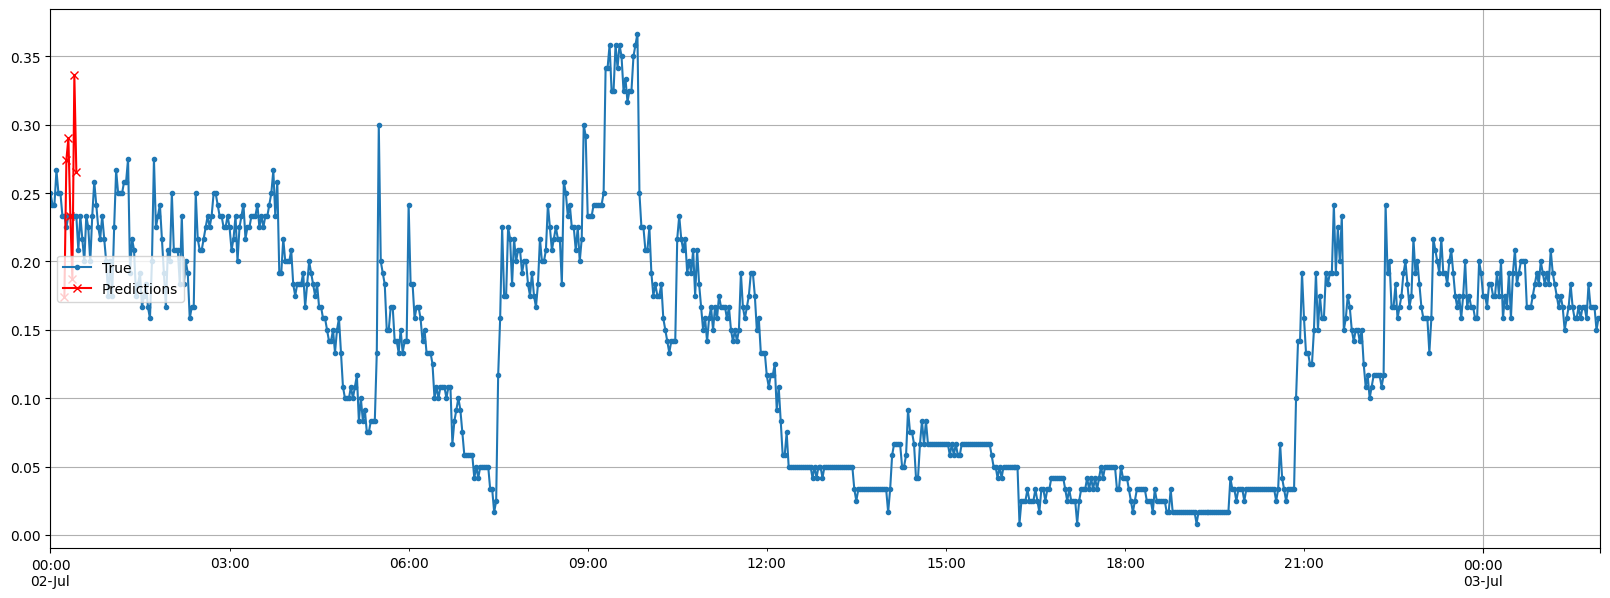

In [221]:
X = test.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = gru.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts.index[sequence_lenght], end=ts.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
plt.show()

#### CNN

In [222]:
seq2seq_cnn_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons*2, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Conv1D(prediction_lenght, kernel_size=1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [223]:
fit_and_evaluate(seq2seq_cnn_model, seq2seq_train, seq2seq_valid)

Epoch 1/10
   2489/Unknown 28s 11ms/step - loss: 0.1722 - mae: 0.4094 - mape: 154.5121

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2499/2499 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 0.1722 - mae: 0.4093 - mape: 154.5410 - val_loss: 0.0575 - val_mae: 0.2003 - val_mape: 93.6748
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - loss: 0.1509 - mae: 0.3731 - mape: 145.8844 - val_loss: 0.0553 - val_mae: 0.1895 - val_mape: 93.0572
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - loss: 0.1463 - mae: 0.3654 - mape: 142.8588 - val_loss: 0.0553 - val_mae: 0.1881 - val_mape: 92.5977
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - loss: 0.1435 - mae: 0.3605 - mape: 142.4997 - val_loss: 0.0546 - val_mae: 0.1786 - val_mape: 92.7291
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.1419 - mae: 0.3580 - mape: 143.4243 - val_loss: 0.0549 - val_mae: 0.1850 - val_mape: 92.2758
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 0.1408 - mae: 0.3561 - mape: 141.9041 - val_loss: 0.0544 - val_mae: 0.1748 - val_mape: 92.8495
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step -

(0.16548699140548706, 93.62593841552734)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


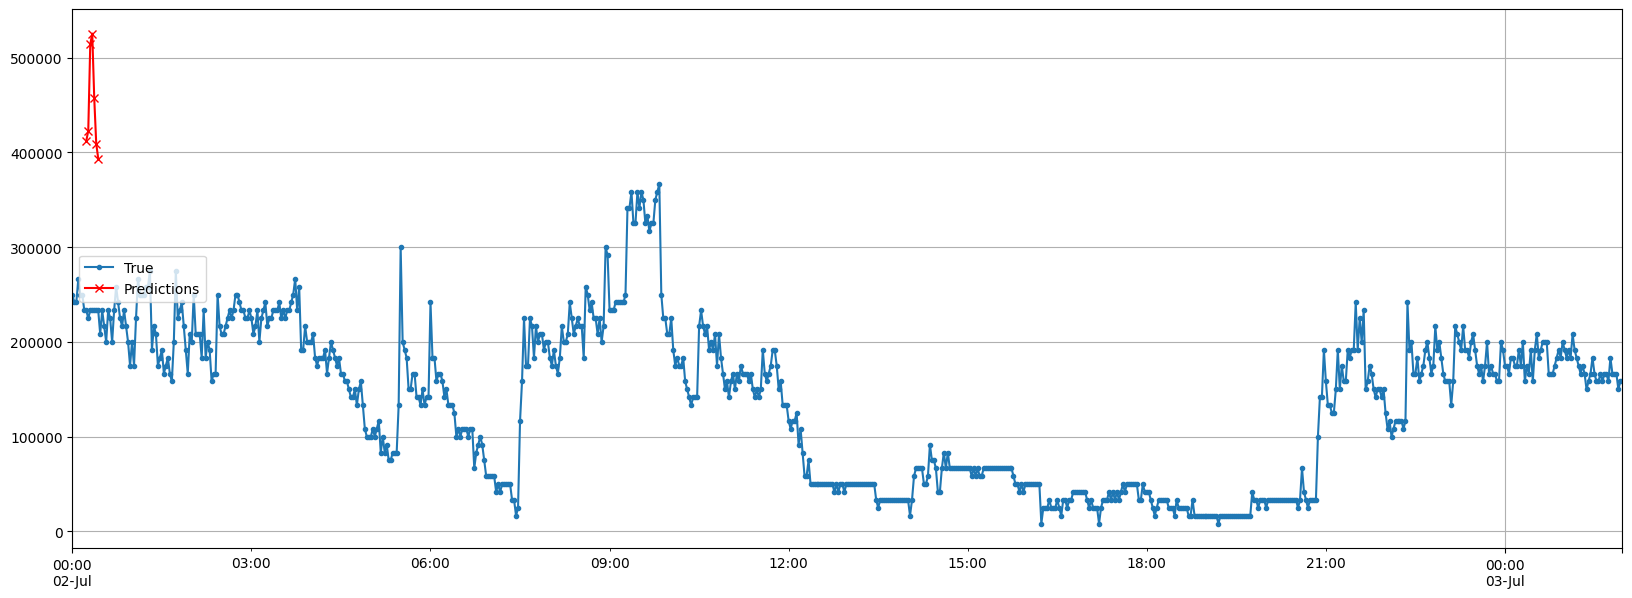

In [224]:
X = test.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_cnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts.index[sequence_lenght], end=ts.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
plt.show()

LSTM and GRU cells are one of the main reasons behind the success of RNNs.
Yet while they can tackle much longer sequences than simple RNNs, they still
have a fairly limited short-term memory, and they have a hard time learning
long-term patterns in sequences of 100 time steps or more, such as audio
samples, long time series, or long sentences. One way to solve this is to shorten
the input sequences; for example, using 1D convolutional layers.

In [225]:
stride = 2
k_size = 4

conv_rnn_model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=k_size, strides=stride, activation="relu", input_shape=[None, num_features]),
  tf.keras.layers.GRU(batch_size, return_sequences=True),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [226]:
longer_train = to_seq2seq_dataset(train, seq_length=sequence_lenght*2, shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(valid, seq_length=sequence_lenght*2)
longer_test = to_seq2seq_dataset(test, seq_length=sequence_lenght*2)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_test = longer_test.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))

In [227]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid)

Epoch 1/10
   2495/Unknown 42s 16ms/step - loss: 0.1764 - mae: 0.4135 - mape: 144.3126

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2499/2499 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - loss: 0.1764 - mae: 0.4134 - mape: 144.3275 - val_loss: 0.0537 - val_mae: 0.1942 - val_mape: 92.8339
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 79s 16ms/step - loss: 0.1386 - mae: 0.3494 - mape: 140.9249 - val_loss: 0.0530 - val_mae: 0.1899 - val_mape: 91.6740
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 0.1356 - mae: 0.3444 - mape: 138.6034 - val_loss: 0.0528 - val_mae: 0.1892 - val_mape: 91.0818
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - loss: 0.1338 - mae: 0.3415 - mape: 138.0667 - val_loss: 0.0527 - val_mae: 0.1872 - val_mape: 90.5711
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - loss: 0.1323 - mae: 0.3388 - mape: 136.9404 - val_loss: 0.0528 - val_mae: 0.1882 - val_mape: 89.9387
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - loss: 0.1316 - mae: 0.3376 - mape: 136.4862 - val_loss: 0.0524 - val_mae: 0.1831 - val_mape: 89.4240
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step -

(0.18100720643997192, 89.40486907958984)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


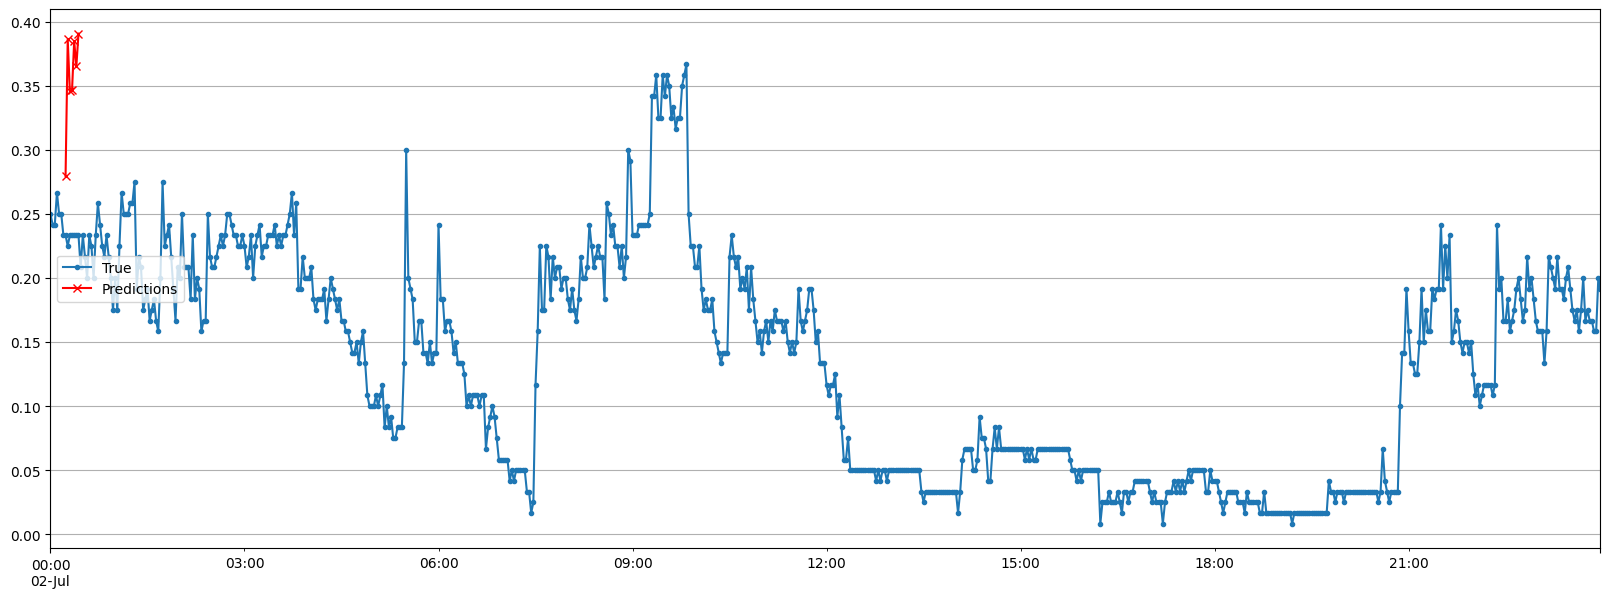

In [229]:
X = test.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = conv_rnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts.index[sequence_lenght], end=ts.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts)[start:start].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
plt.show()

## ARMA family



In [ ]:
from statsmodels.tsa.arima.model import ARIMA

Check for stationarity with the Augmented Dickey-Fuller test

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train['avg_invocations_rate'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


In [ ]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(train['avg_invocations_rate'], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(train['avg_invocations_rate'], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

order=(p, d, q):
* p = the past p values of the time series, "how far back into the past the model should look";
* d = *order of integration*, running d consecutive rounds of differencing computes an approximation of the dth order derivative of the time series, so it will eliminate polynomial trends up to degree d.
* q = the past q forecast errors ε(t);

seasonal_order=(P, D, Q, s)
* P = , D = , Q =  : to model the time series at  (t–s), (t–2s), (t–3s);
* s = the period of the seasonal pattern.


In [ ]:
trimmed_valid = ts.iloc[:-prediction_lenght]
# in realtà dal test risulta stazionaria, ma le performance sembrano migliori
arima = ARIMA(trimmed_valid, order=(1,1,1))
arima = arima.fit()

In [ ]:
# Forecasting
forecast = arima.forecast(steps=prediction_lenght)

plt.figure(figsize=(20, 6))
# Plot the forecast
# original data: full length
plt.plot(ts.index, ts, label='Observed')
plt.plot(pd.date_range(trimmed_valid.index[-1], periods=prediction_lenght, freq=freq), forecast, label='Forecast', color='red')
plt.axvline(trimmed_valid.index[-1], linestyle='--', color='black', label='Forecast Start')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(forecast)